In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import tensorflow as tf
import PIL
import os, glob, random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

VERSION = 2

In [2]:
# see https://medium.com/@JeansPantRushi/fix-for-tensorflow-v2-failed-to-get-convolution-algorithm-b367a088b56e
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.1.0


# Build Model (Tensorflow 2.)

In [9]:
#IMG_HEIGHT, IMG_WIDTH = (64, 48)
IMG_HEIGHT, IMG_WIDTH = (48, 64)

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    #Dense(1, activation='sigmoid')
    Dense(4)
])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 32, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 8, 64)         

# Build training vectors

In [10]:
TRAIN_DIR = 'train'
VALIDATION_DIR = 'validation'

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=5,
                                           width_shift_range=.1,
                                           height_shift_range=.1,
                                           brightness_range=(.5,1.5),
                                           shear_range=0.1,
                                           channel_shift_range=0.1,
                                           zoom_range=0.1,
                                           horizontal_flip=True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=400,
                                                           directory=TRAIN_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=40,
                                                              directory=VALIDATION_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 262 images belonging to 4 classes.
Found 73 images belonging to 4 classes.


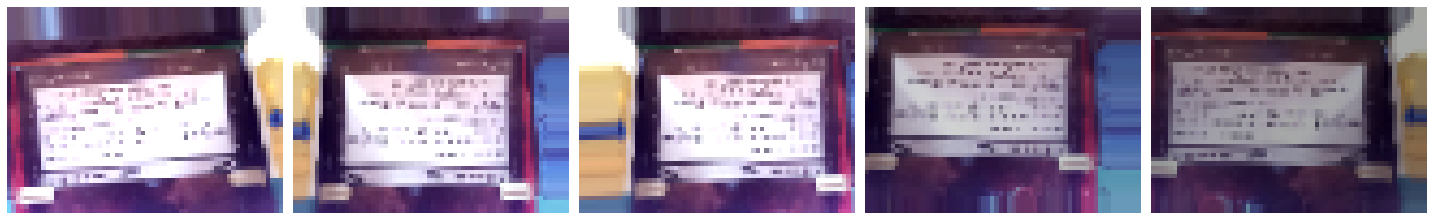

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Train Model

In [15]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples/train_data_gen.batch_size,
    epochs=100,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples/val_data_gen.batch_size,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 0.655 steps, validate for 1.825 steps
Epoch 1/100
1/0 [=============================================] - 1s 1s/step - loss: 0.1394 - accuracy: 0.9466 - val_loss: 0.1213 - val_accuracy: 0.9726
Epoch 2/100
1/0 [=============================================] - 1s 1s/step - loss: 0.1249 - accuracy: 0.9580 - val_loss: 0.1432 - val_accuracy: 0.9452
Epoch 3/100
1/0 [=============================================] - 1s 1s/step - loss: 0.1189 - accuracy: 0.9542 - val_loss: 0.1475 - val_accuracy: 0.9589
Epoch 4/100
1/0 [=============================================] - 1s 1s/step - loss: 0.1216 - accuracy: 0.9542 - val_loss: 0.1620 - val_accuracy: 0.9178
Epoch 5/100
1/0 [=============================================] - 1s 1s/step - loss: 0.1152 - accuracy: 0.9542 - val_loss: 0.1465 - val_accuracy: 0.9589
Epoch 6/100
1/0 [=============================================] - 1s 1s/step - loss: 0.1154 - accuracy: 0.9580 - val_loss: 0.1515 - val_a

Epoch 53/100
1/0 [=============================================] - 1s 1s/step - loss: 0.0820 - accuracy: 0.9771 - val_loss: 0.0613 - val_accuracy: 0.9863
Epoch 54/100
1/0 [=============================================] - 1s 1s/step - loss: 0.0913 - accuracy: 0.9656 - val_loss: 0.0640 - val_accuracy: 0.9863
Epoch 55/100
1/0 [=============================================] - 1s 1s/step - loss: 0.0706 - accuracy: 0.9733 - val_loss: 0.0910 - val_accuracy: 0.9726
Epoch 56/100
1/0 [=============================================] - 1s 1s/step - loss: 0.0685 - accuracy: 0.9695 - val_loss: 0.1275 - val_accuracy: 0.9589
Epoch 57/100
1/0 [=============================================] - 1s 1s/step - loss: 0.0625 - accuracy: 0.9847 - val_loss: 0.1438 - val_accuracy: 0.9452
Epoch 58/100
1/0 [=============================================] - 1s 1s/step - loss: 0.0773 - accuracy: 0.9809 - val_loss: 0.1091 - val_accuracy: 0.9726
Epoch 59/100
1/0 [=============================================] - 1s 1s/ste

# Analysis

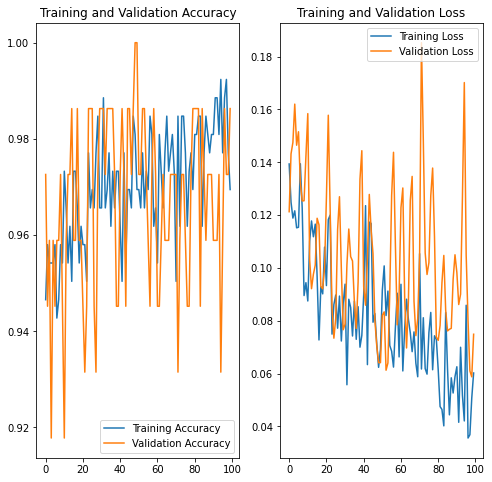

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Save Model

In [17]:
#model.save_weights('./back_front_v000') # only saves the weights, not the structure
model.save('mtg_back_front_classifier_v%03d' % VERSION)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mtg_back_front_classifier_v002/assets
